<a href="https://colab.research.google.com/github/vhinatav/Computer-Vision-Project/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Trash Detection (YOLO) <b> </h1></center>



In [26]:
#Importing required Libraries
import matplotlib.pyplot as plt
from PIL import Image
import os

# Dataset






Recyclable and Household Waste Classification

available on kaggle => https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification


# Data Preprocessing


**trash_data**
- images (png & jpeg)
  - train (20 images/class × 4)
  - val (20 images/class × 4)
- labels (txt)
  - train (20 labels/class × 4)
  - val (20 labels/class × 4)

**4 different colours of trash bin**
- Black (landfill)
- Blue (recycle)
- Yellow (mix paper)
- Green (composable)

In [27]:
#set the paths to labels and images directory
label_dir= "/content/trash_data/labels"
image_dir="/content/trash_data/images"

## Checking Missing Files


Checking the folders if every image file has a corresponding label file


(We will copy the code, we already used in previous turorial after updating)

In [ ]:
#The lists of all the images and labels for train and validation set:
train_images=glob.glob(os.path.join(image_dir, "train",'*.jpg'))
train_labels=glob.glob(os.path.join(label_dir, "train",'*.txt'))
val_images=glob.glob(os.path.join(image_dir, "val",'*.jpg'))
val_labels=glob.glob(os.path.join(label_dir, "val",'*.txt'))
#print(val_labels)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] for file in val_labels}
#print(image_files_val)



In [ ]:
print(len(image_files_val), "  =  ", len(label_files_val))

0   =   120


In [ ]:
# Find extra files in each folder

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


#VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): set()
Training Extra labels (without corresponding images): {'green_t58', 'blue_t12', 'yellow_t1008', 'blue_t15', 'yellow_t8', 'yellow_t1014', 'blue_t5', 'yellow_t1015', 'yellow_t33', 'green_t55', 'yellow_t46', 'blue_t17', 'yellow_t21', 'yellow_t50', 'yellow_t32', 'blue_t26', 'black_t1', 'black_t10', 'green_t12', 'blue_t18', 'blue_t4', 'blue_t23', 'yellow_t53', 'yellow_t1017', 'yellow_t1010', 'yellow_t1016', 'black_t14', 'green_t17', 'black_t12', 'yellow_t1012', 'yellow_t52', 'yellow_t1007', 'green_t19', 'yellow_t43', 'black_t4', 'blue_t21', 'blue_t30', 'blue_t29', 'blue_t28', 'yellow_t17', 'blue_t34', 'green_t39', 'blue_t22', 'blue_t38', 'yellow_t1001', 'yellow_t89', 'blue_t37', 'yellow_t5', 'yellow_t35', 'black_t9', 'black_t13', 'blue_t39', 'blue_t8', 'yellow_t1009', 'green_t7', 'green_t45', 'yellow_t51', 'black_t6', 'green_t4', 'yellow_t1003', 'Image_t20', 'blue_t27', 'yellow_t1004', 'blue_t13', 'black_t16', 'blue_t10', 'yellow_t

Make sure that the above info is correct by chceking the data manually.

Now removing from the dataset:

In [ ]:
for file in extra_images_train:
     os.remove(os.path.join(image_dir, "train", file + '.jpg')) # or '.png' depending on your image format

for file in extra_images_val:
     os.remove(os.path.join(image_dir, "val", file + '.jpg'))

Now run the above cells again to find if all the missing data is deleted.

# Custom object detection using YOLO

In [28]:
#install & import
%pip install ultralytics
import ultralytics
ultralytics.checks()

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [29]:
from ultralytics import YOLO

## Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [37]:
model = YOLO('yolov8s.pt') # pretrained model

The detailed architecture of the model can be seen from:


In [38]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [39]:
%%writefile config.yaml
path: /content/trash_data
train: /content/trash_data/images/train
#test: (test dataset folder path)
val: /content/trash_data/images/val

# Classes
nc: 4 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: black
  1: blue
  2: yellow
  3: green

Overwriting config.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [40]:
model.train(data="config.yaml",epochs=5,patience=5,batch=8, lr0=0.0005,imgsz=640)

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=config.yaml, epochs=5, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=

train: Scanning /content/trash_data/labels/train.cache... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/trash_data/labels/val.cache... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.88G      1.121      3.266      1.602         16        640: 100%|██████████| 18/18 [00:03<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

                   all        140        356       0.26      0.154       0.14     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.81G      0.933      1.897       1.43         14        640: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.06it/s]

                   all        140        356      0.523      0.421      0.436      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.86G     0.8441      1.576      1.337         19        640: 100%|██████████| 18/18 [00:05<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]


                   all        140        356      0.537      0.539      0.492      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.73G     0.9095      1.387      1.354         14        640: 100%|██████████| 18/18 [00:04<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.74it/s]

                   all        140        356      0.676      0.437      0.503      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.77G      0.889      1.315      1.352         14        640: 100%|██████████| 18/18 [00:03<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]

                   all        140        356      0.639      0.495      0.511      0.359



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 22.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]


                   all        140        356      0.675      0.437      0.502       0.36
                 black         20         34      0.807      0.265      0.442      0.301
                  blue         40         94      0.824      0.796      0.849      0.651
                yellow         60        195      0.458      0.231      0.241      0.153
                 green         20         33      0.612      0.455      0.477      0.334
Speed: 0.4ms preprocess, 6.4ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa7c613e590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [41]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/trash_data/labels/val.cache... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.87it/s]


                   all        140        356       0.67      0.437      0.505       0.36
                 black         20         34      0.805      0.265      0.447      0.305
                  blue         40         94      0.821      0.798      0.854      0.651
                yellow         60        195      0.446      0.231      0.243      0.152
                 green         20         33      0.609      0.455      0.477      0.334
Speed: 0.3ms preprocess, 10.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train52


0.4369732270232896

Showing confusion matrix, that is already stored in detect/train folder

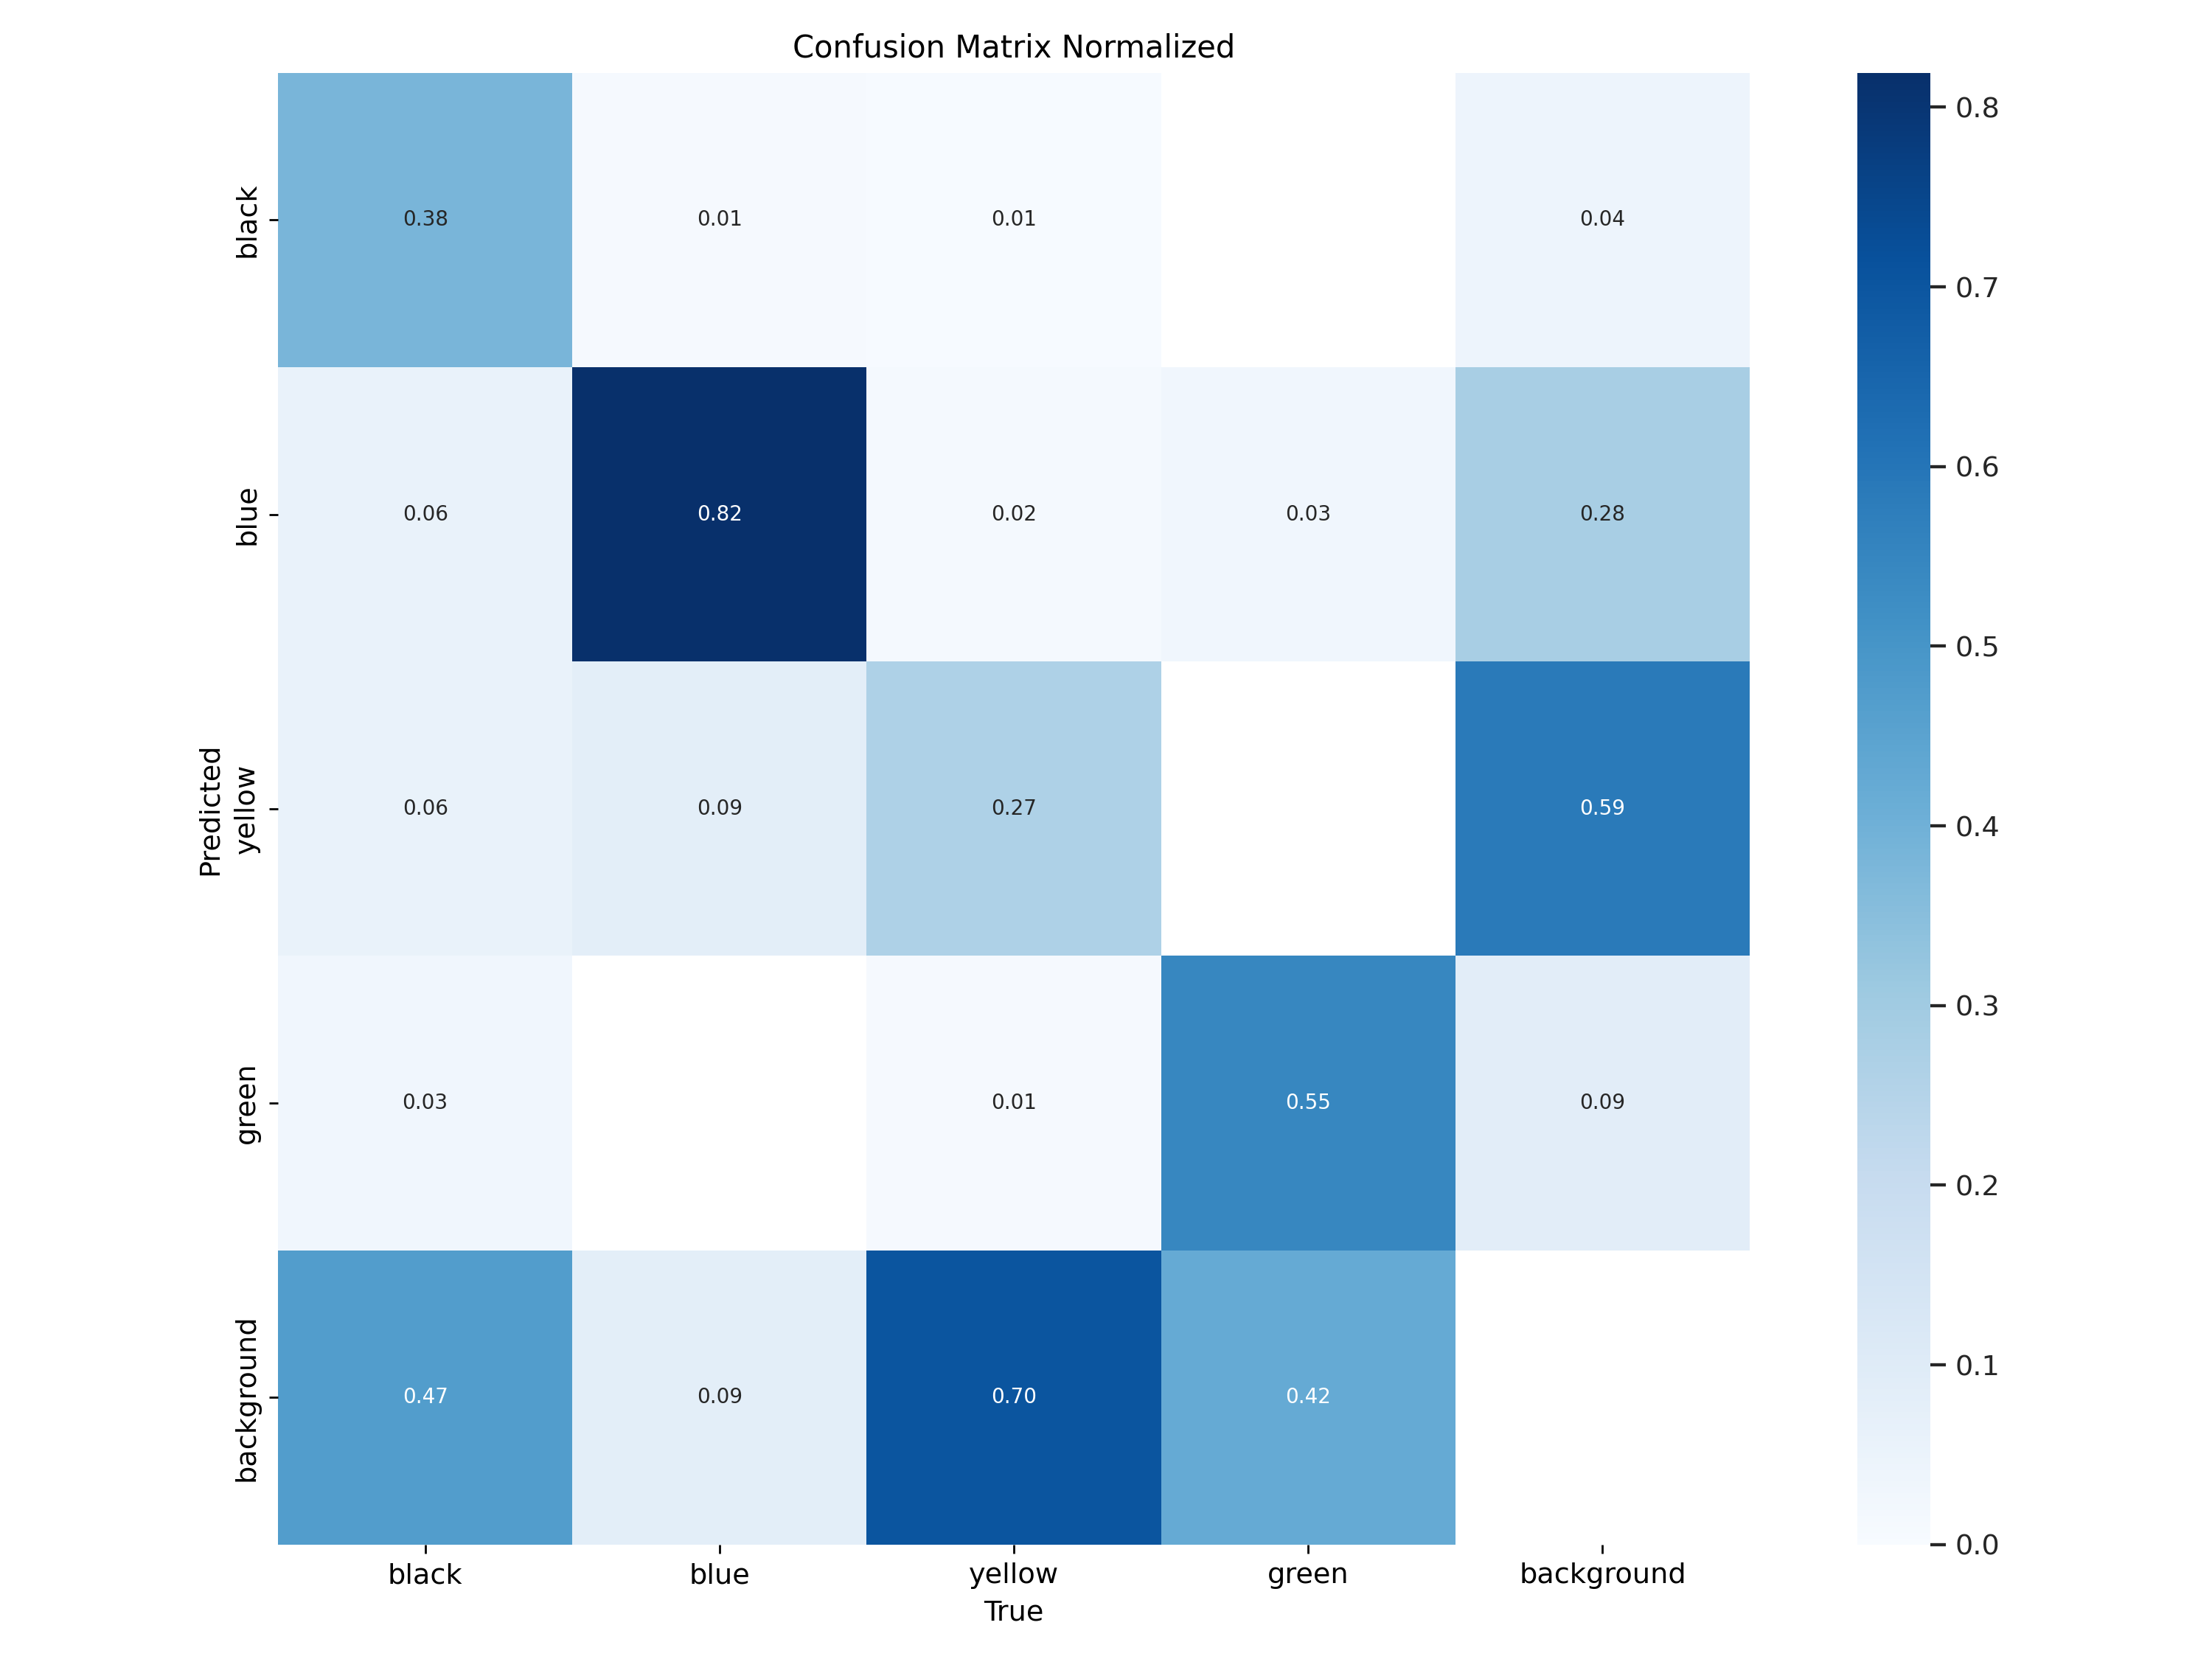

In [42]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/train52/confusion_matrix_normalized.png')

##Prediction

In [25]:
#model = YOLO('yolov8s.pt')  # load a custom model

# Predict with the model with any image from internet?
results = model('/content/test_2.jpeg', save=True)

FileNotFoundError: /content/test_2.jpeg does not exist

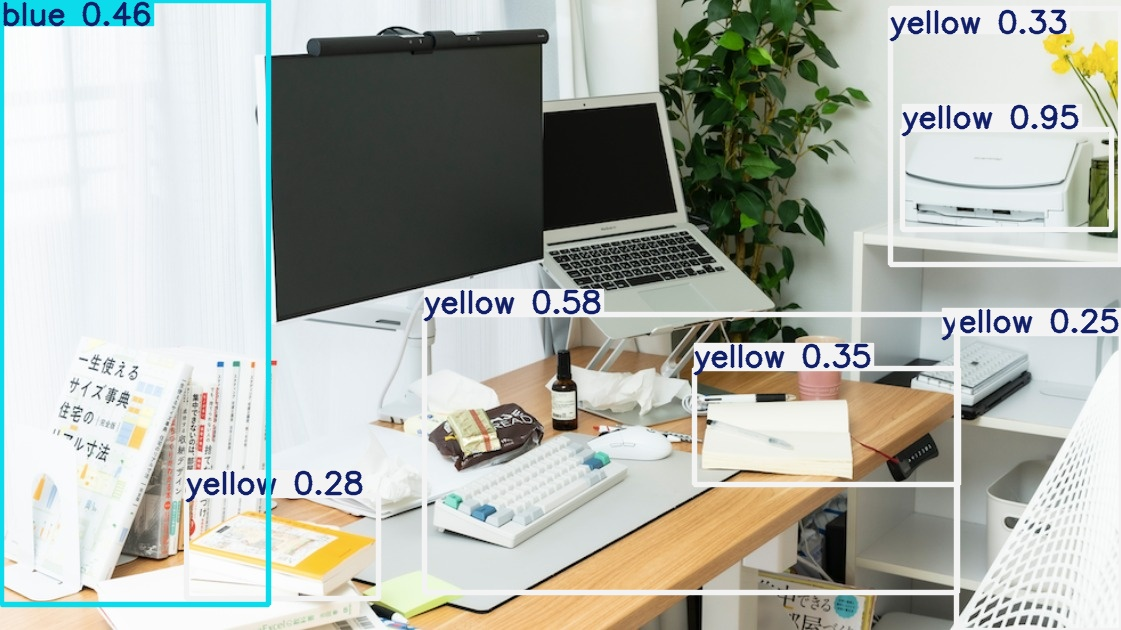

In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/train34/test_2.jpg')